# *Future Frame Prediction for Anomaly Detection – A New Baseline*

### Test the pre-trained model on several datasets

In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import pickle


from models import generator
from utils import DataLoader, load, save, psnr_error
from constant import const
import evaluate

checkpoints/pretrains/ped2


In [2]:
const.SNAPSHOT_DIR 

'checkpoints/pretrains/ped2'

In [3]:
slim = tf.contrib.slim

os.environ['CUDA_DEVICES_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = const.GPU

dataset_name = const.DATASET
test_folder = const.TEST_FOLDER

num_his = const.NUM_HIS
height, width = 256, 256

snapshot_dir = const.SNAPSHOT_DIR
psnr_dir = const.PSNR_DIR
evaluate_name = const.EVALUATE

In [4]:
# define dataset
with tf.name_scope('dataset'):
    test_video_clips_tensor = tf.placeholder(shape=[1, height, width, 3 * (num_his + 1)],
                                             dtype=tf.float32)
    test_inputs = test_video_clips_tensor[..., 0:num_his*3]
    test_gt = test_video_clips_tensor[..., -3:]
    print('test inputs = {}'.format(test_inputs))
    print('test prediction gt = {}'.format(test_gt))

test inputs = Tensor("dataset/strided_slice:0", shape=(1, 256, 256, 12), dtype=float32)
test prediction gt = Tensor("dataset/strided_slice_1:0", shape=(1, 256, 256, 3), dtype=float32)


In [5]:
# define testing generator function and
# in testing, only generator networks, there is no discriminator networks and flownet.
with tf.variable_scope('generator', reuse=None):
    print('testing = {}'.format(tf.get_variable_scope().name))
    test_outputs = generator(test_inputs, layers=4, output_channel=3)
    test_psnr_error = psnr_error(gen_frames=test_outputs, gt_frames=test_gt)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    # dataset
    data_loader = DataLoader(test_folder, height, width)

    # initialize weights
    sess.run(tf.global_variables_initializer())
    print('Init global successfully!')

    # tf saver
    saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=None)

    restore_var = [v for v in tf.global_variables()]
    loader = tf.train.Saver(var_list=restore_var)

    def inference_func(ckpt, dataset_name, evaluate_name):
        load(loader, sess, ckpt)

        psnr_records = []
        videos_info = data_loader.videos
        num_videos = len(videos_info.keys())
        total = 0
        timestamp = time.time()

        for video_name, video in videos_info.items():
            length = video['length']
            total += length
            psnrs = np.empty(shape=(length,), dtype=np.float32)

            for i in range(num_his, length):
                video_clip = data_loader.get_video_clips(video_name, i - num_his, i + 1)
                psnr = sess.run(test_psnr_error,
                                feed_dict={test_video_clips_tensor: video_clip[np.newaxis, ...]})
                psnrs[i] = psnr

                print('video = {} / {}, i = {} / {}, psnr = {:.6f}'.format(
                    video_name, num_videos, i, length, psnr))

            psnrs[0:num_his] = psnrs[num_his]
            psnr_records.append(psnrs)

        result_dict = {'dataset': dataset_name, 'psnr': psnr_records, 'flow': [], 'names': [], 'diff_mask': []}

        used_time = time.time() - timestamp
        print('total time = {}, fps = {}'.format(used_time, total / used_time))

        # TODO specify what's the actual name of ckpt.
        pickle_path = os.path.join(psnr_dir, os.path.split(ckpt)[-1])
        with open(pickle_path, 'wb') as writer:
            pickle.dump(result_dict, writer, pickle.HIGHEST_PROTOCOL)

        results = evaluate.evaluate(evaluate_name, pickle_path)
        print(results)


    if os.path.isdir(snapshot_dir):
        def check_ckpt_valid(ckpt_name):
            is_valid = False
            ckpt = ''
            if ckpt_name.startswith('model.ckpt-'):
                ckpt_name_splits = ckpt_name.split('.')
                ckpt = str(ckpt_name_splits[0]) + '.' + str(ckpt_name_splits[1])
                ckpt_path = os.path.join(snapshot_dir, ckpt)
                if os.path.exists(ckpt_path + '.index') and os.path.exists(ckpt_path + '.meta') and \
                        os.path.exists(ckpt_path + '.data-00000-of-00001'):
                    is_valid = True

            return is_valid, ckpt

        def scan_psnr_folder():
            tested_ckpt_in_psnr_sets = set()
            for test_psnr in os.listdir(psnr_dir):
                tested_ckpt_in_psnr_sets.add(test_psnr)
            return tested_ckpt_in_psnr_sets

        def scan_model_folder():
            saved_models = set()
            for ckpt_name in os.listdir(snapshot_dir):
                is_valid, ckpt = check_ckpt_valid(ckpt_name)
                if is_valid:
                    saved_models.add(ckpt)
            return saved_models

        tested_ckpt_sets = scan_psnr_folder()
        while True:
            all_model_ckpts = scan_model_folder()
            new_model_ckpts = all_model_ckpts - tested_ckpt_sets

            for ckpt_name in new_model_ckpts:
                # inference
                ckpt = os.path.join(snapshot_dir, ckpt_name)
                inference_func(ckpt, dataset_name, evaluate_name)

                tested_ckpt_sets.add(ckpt_name)

            print('waiting for models...')
            evaluate.evaluate('compute_auc', psnr_dir)
            time.sleep(60)
    else:
        inference_func(snapshot_dir, dataset_name, evaluate_name)

testing = generator
Init global successfully!
INFO:tensorflow:Restoring parameters from checkpoints/pretrains/ped2
Restored model parameters from checkpoints/pretrains/ped2
video = 01 / 12, i = 4 / 180, psnr = 37.473366
video = 01 / 12, i = 5 / 180, psnr = 37.717838
video = 01 / 12, i = 6 / 180, psnr = 37.365299
video = 01 / 12, i = 7 / 180, psnr = 38.039967
video = 01 / 12, i = 8 / 180, psnr = 37.886757
video = 01 / 12, i = 9 / 180, psnr = 37.945099
video = 01 / 12, i = 10 / 180, psnr = 37.798424
video = 01 / 12, i = 11 / 180, psnr = 37.928917
video = 01 / 12, i = 12 / 180, psnr = 37.309025
video = 01 / 12, i = 13 / 180, psnr = 37.852200
video = 01 / 12, i = 14 / 180, psnr = 38.045128
video = 01 / 12, i = 15 / 180, psnr = 37.725426
video = 01 / 12, i = 16 / 180, psnr = 37.575336
video = 01 / 12, i = 17 / 180, psnr = 38.032768
video = 01 / 12, i = 18 / 180, psnr = 37.789150
video = 01 / 12, i = 19 / 180, psnr = 38.342892
video = 01 / 12, i = 20 / 180, psnr = 38.230400
video = 01 / 12, 

video = 01 / 12, i = 172 / 180, psnr = 35.741913
video = 01 / 12, i = 173 / 180, psnr = 36.049500
video = 01 / 12, i = 174 / 180, psnr = 36.428879
video = 01 / 12, i = 175 / 180, psnr = 35.855030
video = 01 / 12, i = 176 / 180, psnr = 35.736237
video = 01 / 12, i = 177 / 180, psnr = 35.975426
video = 01 / 12, i = 178 / 180, psnr = 35.902962
video = 01 / 12, i = 179 / 180, psnr = 36.225140
video = 02 / 12, i = 4 / 180, psnr = 39.661961
video = 02 / 12, i = 5 / 180, psnr = 39.476364
video = 02 / 12, i = 6 / 180, psnr = 39.223255
video = 02 / 12, i = 7 / 180, psnr = 39.174282
video = 02 / 12, i = 8 / 180, psnr = 38.545589
video = 02 / 12, i = 9 / 180, psnr = 38.785595
video = 02 / 12, i = 10 / 180, psnr = 38.885868
video = 02 / 12, i = 11 / 180, psnr = 39.110054
video = 02 / 12, i = 12 / 180, psnr = 39.115654
video = 02 / 12, i = 13 / 180, psnr = 39.240620
video = 02 / 12, i = 14 / 180, psnr = 39.243275
video = 02 / 12, i = 15 / 180, psnr = 38.681927
video = 02 / 12, i = 16 / 180, psnr = 

video = 02 / 12, i = 171 / 180, psnr = 34.261307
video = 02 / 12, i = 172 / 180, psnr = 34.587734
video = 02 / 12, i = 173 / 180, psnr = 35.426525
video = 02 / 12, i = 174 / 180, psnr = 35.886272
video = 02 / 12, i = 175 / 180, psnr = 35.819626
video = 02 / 12, i = 176 / 180, psnr = 35.284733
video = 02 / 12, i = 177 / 180, psnr = 35.211452
video = 02 / 12, i = 178 / 180, psnr = 35.232738
video = 02 / 12, i = 179 / 180, psnr = 35.592468
video = 03 / 12, i = 4 / 150, psnr = 36.195305
video = 03 / 12, i = 5 / 150, psnr = 36.681866
video = 03 / 12, i = 6 / 150, psnr = 36.208084
video = 03 / 12, i = 7 / 150, psnr = 36.227253
video = 03 / 12, i = 8 / 150, psnr = 36.275291
video = 03 / 12, i = 9 / 150, psnr = 36.312374
video = 03 / 12, i = 10 / 150, psnr = 36.227287
video = 03 / 12, i = 11 / 150, psnr = 36.219509
video = 03 / 12, i = 12 / 150, psnr = 36.456757
video = 03 / 12, i = 13 / 150, psnr = 36.334240
video = 03 / 12, i = 14 / 150, psnr = 36.418255
video = 03 / 12, i = 15 / 150, psnr =

video = 04 / 12, i = 29 / 180, psnr = 39.759789
video = 04 / 12, i = 30 / 180, psnr = 39.547657
video = 04 / 12, i = 31 / 180, psnr = 39.347187
video = 04 / 12, i = 32 / 180, psnr = 38.700237
video = 04 / 12, i = 33 / 180, psnr = 38.928604
video = 04 / 12, i = 34 / 180, psnr = 39.009304
video = 04 / 12, i = 35 / 180, psnr = 39.240166
video = 04 / 12, i = 36 / 180, psnr = 39.202564
video = 04 / 12, i = 37 / 180, psnr = 38.790989
video = 04 / 12, i = 38 / 180, psnr = 38.723755
video = 04 / 12, i = 39 / 180, psnr = 38.582020
video = 04 / 12, i = 40 / 180, psnr = 38.248081
video = 04 / 12, i = 41 / 180, psnr = 37.914753
video = 04 / 12, i = 42 / 180, psnr = 38.054237
video = 04 / 12, i = 43 / 180, psnr = 38.390778
video = 04 / 12, i = 44 / 180, psnr = 38.008995
video = 04 / 12, i = 45 / 180, psnr = 38.000320
video = 04 / 12, i = 46 / 180, psnr = 37.262569
video = 04 / 12, i = 47 / 180, psnr = 37.460220
video = 04 / 12, i = 48 / 180, psnr = 37.121685
video = 04 / 12, i = 49 / 180, psnr = 37

video = 05 / 12, i = 34 / 150, psnr = 35.783249
video = 05 / 12, i = 35 / 150, psnr = 35.862858
video = 05 / 12, i = 36 / 150, psnr = 35.492863
video = 05 / 12, i = 37 / 150, psnr = 36.150677
video = 05 / 12, i = 38 / 150, psnr = 35.935860
video = 05 / 12, i = 39 / 150, psnr = 35.929722
video = 05 / 12, i = 40 / 150, psnr = 35.863628
video = 05 / 12, i = 41 / 150, psnr = 35.603180
video = 05 / 12, i = 42 / 150, psnr = 35.539764
video = 05 / 12, i = 43 / 150, psnr = 35.440918
video = 05 / 12, i = 44 / 150, psnr = 35.648232
video = 05 / 12, i = 45 / 150, psnr = 35.630253
video = 05 / 12, i = 46 / 150, psnr = 35.643818
video = 05 / 12, i = 47 / 150, psnr = 35.626053
video = 05 / 12, i = 48 / 150, psnr = 35.168518
video = 05 / 12, i = 49 / 150, psnr = 35.579304
video = 05 / 12, i = 50 / 150, psnr = 35.658306
video = 05 / 12, i = 51 / 150, psnr = 35.645802
video = 05 / 12, i = 52 / 150, psnr = 35.666454
video = 05 / 12, i = 53 / 150, psnr = 35.898327
video = 05 / 12, i = 54 / 150, psnr = 35

video = 06 / 12, i = 62 / 180, psnr = 34.410717
video = 06 / 12, i = 63 / 180, psnr = 34.366341
video = 06 / 12, i = 64 / 180, psnr = 34.715172
video = 06 / 12, i = 65 / 180, psnr = 34.662865
video = 06 / 12, i = 66 / 180, psnr = 34.742466
video = 06 / 12, i = 67 / 180, psnr = 34.831844
video = 06 / 12, i = 68 / 180, psnr = 34.779728
video = 06 / 12, i = 69 / 180, psnr = 34.707977
video = 06 / 12, i = 70 / 180, psnr = 34.705708
video = 06 / 12, i = 71 / 180, psnr = 34.876972
video = 06 / 12, i = 72 / 180, psnr = 34.476486
video = 06 / 12, i = 73 / 180, psnr = 34.486145
video = 06 / 12, i = 74 / 180, psnr = 34.908852
video = 06 / 12, i = 75 / 180, psnr = 34.698803
video = 06 / 12, i = 76 / 180, psnr = 34.795509
video = 06 / 12, i = 77 / 180, psnr = 34.910980
video = 06 / 12, i = 78 / 180, psnr = 34.784576
video = 06 / 12, i = 79 / 180, psnr = 34.880199
video = 06 / 12, i = 80 / 180, psnr = 34.926003
video = 06 / 12, i = 81 / 180, psnr = 34.686371
video = 06 / 12, i = 82 / 180, psnr = 34

video = 07 / 12, i = 57 / 180, psnr = 37.783024
video = 07 / 12, i = 58 / 180, psnr = 37.913586
video = 07 / 12, i = 59 / 180, psnr = 37.858612
video = 07 / 12, i = 60 / 180, psnr = 37.442326
video = 07 / 12, i = 61 / 180, psnr = 37.539516
video = 07 / 12, i = 62 / 180, psnr = 37.517227
video = 07 / 12, i = 63 / 180, psnr = 37.155331
video = 07 / 12, i = 64 / 180, psnr = 37.415134
video = 07 / 12, i = 65 / 180, psnr = 37.616982
video = 07 / 12, i = 66 / 180, psnr = 37.608604
video = 07 / 12, i = 67 / 180, psnr = 37.728401
video = 07 / 12, i = 68 / 180, psnr = 37.417377
video = 07 / 12, i = 69 / 180, psnr = 37.444321
video = 07 / 12, i = 70 / 180, psnr = 37.246983
video = 07 / 12, i = 71 / 180, psnr = 37.023575
video = 07 / 12, i = 72 / 180, psnr = 37.620888
video = 07 / 12, i = 73 / 180, psnr = 37.455009
video = 07 / 12, i = 74 / 180, psnr = 37.753136
video = 07 / 12, i = 75 / 180, psnr = 37.386379
video = 07 / 12, i = 76 / 180, psnr = 37.646473
video = 07 / 12, i = 77 / 180, psnr = 38

video = 08 / 12, i = 51 / 180, psnr = 37.467373
video = 08 / 12, i = 52 / 180, psnr = 37.393730
video = 08 / 12, i = 53 / 180, psnr = 37.533016
video = 08 / 12, i = 54 / 180, psnr = 37.162441
video = 08 / 12, i = 55 / 180, psnr = 36.961929
video = 08 / 12, i = 56 / 180, psnr = 37.017578
video = 08 / 12, i = 57 / 180, psnr = 36.793423
video = 08 / 12, i = 58 / 180, psnr = 36.746033
video = 08 / 12, i = 59 / 180, psnr = 36.906227
video = 08 / 12, i = 60 / 180, psnr = 36.370918
video = 08 / 12, i = 61 / 180, psnr = 36.567783
video = 08 / 12, i = 62 / 180, psnr = 36.871830
video = 08 / 12, i = 63 / 180, psnr = 36.843300
video = 08 / 12, i = 64 / 180, psnr = 37.110760
video = 08 / 12, i = 65 / 180, psnr = 36.802208
video = 08 / 12, i = 66 / 180, psnr = 36.910076
video = 08 / 12, i = 67 / 180, psnr = 36.776093
video = 08 / 12, i = 68 / 180, psnr = 37.048096
video = 08 / 12, i = 69 / 180, psnr = 37.335472
video = 08 / 12, i = 70 / 180, psnr = 37.348022
video = 08 / 12, i = 71 / 180, psnr = 37

video = 09 / 12, i = 45 / 120, psnr = 37.589745
video = 09 / 12, i = 46 / 120, psnr = 37.532810
video = 09 / 12, i = 47 / 120, psnr = 37.410583
video = 09 / 12, i = 48 / 120, psnr = 36.828938
video = 09 / 12, i = 49 / 120, psnr = 37.248524
video = 09 / 12, i = 50 / 120, psnr = 37.030281
video = 09 / 12, i = 51 / 120, psnr = 37.144665
video = 09 / 12, i = 52 / 120, psnr = 37.206200
video = 09 / 12, i = 53 / 120, psnr = 37.350235
video = 09 / 12, i = 54 / 120, psnr = 37.127552
video = 09 / 12, i = 55 / 120, psnr = 37.280758
video = 09 / 12, i = 56 / 120, psnr = 37.069893
video = 09 / 12, i = 57 / 120, psnr = 37.177971
video = 09 / 12, i = 58 / 120, psnr = 36.941135
video = 09 / 12, i = 59 / 120, psnr = 37.277206
video = 09 / 12, i = 60 / 120, psnr = 36.875168
video = 09 / 12, i = 61 / 120, psnr = 37.137218
video = 09 / 12, i = 62 / 120, psnr = 37.033325
video = 09 / 12, i = 63 / 120, psnr = 36.906307
video = 09 / 12, i = 64 / 120, psnr = 36.840309
video = 09 / 12, i = 65 / 120, psnr = 37

video = 10 / 12, i = 104 / 150, psnr = 39.606373
video = 10 / 12, i = 105 / 150, psnr = 39.405319
video = 10 / 12, i = 106 / 150, psnr = 39.593304
video = 10 / 12, i = 107 / 150, psnr = 39.679527
video = 10 / 12, i = 108 / 150, psnr = 39.422428
video = 10 / 12, i = 109 / 150, psnr = 39.210880
video = 10 / 12, i = 110 / 150, psnr = 39.433941
video = 10 / 12, i = 111 / 150, psnr = 39.749149
video = 10 / 12, i = 112 / 150, psnr = 39.445950
video = 10 / 12, i = 113 / 150, psnr = 39.463509
video = 10 / 12, i = 114 / 150, psnr = 39.012341
video = 10 / 12, i = 115 / 150, psnr = 39.501564
video = 10 / 12, i = 116 / 150, psnr = 39.767464
video = 10 / 12, i = 117 / 150, psnr = 39.651928
video = 10 / 12, i = 118 / 150, psnr = 39.360420
video = 10 / 12, i = 119 / 150, psnr = 39.330532
video = 10 / 12, i = 120 / 150, psnr = 39.075520
video = 10 / 12, i = 121 / 150, psnr = 39.146343
video = 10 / 12, i = 122 / 150, psnr = 38.743683
video = 10 / 12, i = 123 / 150, psnr = 39.315643
video = 10 / 12, i =

video = 11 / 12, i = 131 / 180, psnr = 35.545525
video = 11 / 12, i = 132 / 180, psnr = 35.249939
video = 11 / 12, i = 133 / 180, psnr = 35.068119
video = 11 / 12, i = 134 / 180, psnr = 35.303833
video = 11 / 12, i = 135 / 180, psnr = 35.052841
video = 11 / 12, i = 136 / 180, psnr = 34.761749
video = 11 / 12, i = 137 / 180, psnr = 35.334850
video = 11 / 12, i = 138 / 180, psnr = 35.110664
video = 11 / 12, i = 139 / 180, psnr = 35.517666
video = 11 / 12, i = 140 / 180, psnr = 35.350887
video = 11 / 12, i = 141 / 180, psnr = 35.265244
video = 11 / 12, i = 142 / 180, psnr = 35.269596
video = 11 / 12, i = 143 / 180, psnr = 35.542126
video = 11 / 12, i = 144 / 180, psnr = 34.773781
video = 11 / 12, i = 145 / 180, psnr = 35.235004
video = 11 / 12, i = 146 / 180, psnr = 35.412727
video = 11 / 12, i = 147 / 180, psnr = 35.260540
video = 11 / 12, i = 148 / 180, psnr = 35.176884
video = 11 / 12, i = 149 / 180, psnr = 35.344589
video = 11 / 12, i = 150 / 180, psnr = 35.005489
video = 11 / 12, i =

video = 12 / 12, i = 131 / 180, psnr = 36.553661
video = 12 / 12, i = 132 / 180, psnr = 36.349438
video = 12 / 12, i = 133 / 180, psnr = 36.663193
video = 12 / 12, i = 134 / 180, psnr = 36.683254
video = 12 / 12, i = 135 / 180, psnr = 37.250259
video = 12 / 12, i = 136 / 180, psnr = 37.308064
video = 12 / 12, i = 137 / 180, psnr = 37.170944
video = 12 / 12, i = 138 / 180, psnr = 36.825756
video = 12 / 12, i = 139 / 180, psnr = 36.772415
video = 12 / 12, i = 140 / 180, psnr = 36.690781
video = 12 / 12, i = 141 / 180, psnr = 36.926025
video = 12 / 12, i = 142 / 180, psnr = 37.169479
video = 12 / 12, i = 143 / 180, psnr = 37.144905
video = 12 / 12, i = 144 / 180, psnr = 36.900372
video = 12 / 12, i = 145 / 180, psnr = 36.938141
video = 12 / 12, i = 146 / 180, psnr = 37.574398
video = 12 / 12, i = 147 / 180, psnr = 37.331093
video = 12 / 12, i = 148 / 180, psnr = 36.860939
video = 12 / 12, i = 149 / 180, psnr = 36.772892
video = 12 / 12, i = 150 / 180, psnr = 36.798626
video = 12 / 12, i =

# Visualize prediction module output

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# ckpt_name = 'model.ckpt-1000'
# ckpt = os.path.join(snapshot_dir, ckpt_name)
video_name = '01'
i = 115
with tf.Session(config=config) as sess:
    load(loader, sess, snapshot_dir)
    video_clip = data_loader.get_video_clips(video_name, i - num_his, i + 1) # video clip size is (W,H,(4+1)*3)
    pred_frame = sess.run(test_outputs,
                        feed_dict={test_video_clips_tensor: video_clip[np.newaxis, ...]})
    gt_frame = video_clip[:,:,-3:]

INFO:tensorflow:Restoring parameters from checkpoints/pretrains/ped2
Restored model parameters from checkpoints/pretrains/ped2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


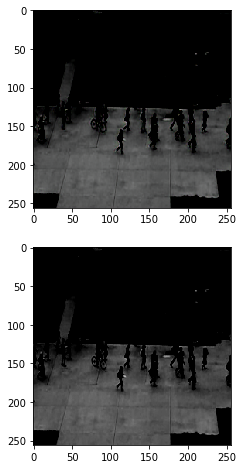

In [18]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)
ax1.imshow(pred_frame[0])
ax2.imshow(gt_frame)

In [55]:
import glob
import numpy as np
file = open('/media/DATA/VAD_datasets/UCF_Crimes/Temporal_Anomaly_Annotation_For_Testing_Videos/Txt_formate/Temporal_Anomaly_Annotation.txt',
            'r')
gt = []
for line in file:
    data = line[:-1].split('  ')[:-1]
    video_name = data[0].split('.')[0]
    num_frames = len(glob.glob('/media/DATA/VAD_datasets/UCF_Crimes/frames/testing/' + video_name + '/*'))
    anomaly_type = data[1]
    
    label = np.zeros(num_frames)
    for i in range(int(len(data[2:])/2)):
        start = int(data[i*2+2])
        end = int(data[i*2+3])
        if start == -1:
            break
        label[start:end] = 1
    gt.append(label)

In [60]:
data

['Abuse028_x264.mp4', 'Abuse', '165', '240', '-1', '-1']